In [10]:
import numpy as np

def model(ini, time_step, params):
    Y = np.zeros(3) #column vector for the state variables
    X = ini
    mu = 0
    beta = params[0]
    gamma = params[1]

    Y[0] = mu - beta*X[0]*X[1] - mu*X[0] #S
    Y[1] = beta*X[0]*X[1] - gamma*X[1] - mu*X[1] #I
    Y[2] = gamma*X[1] - mu*X[2] #R

    return Y

def x0fcn(params, data):
    S0 = 1.0 - (data[0]/params[2])
    I0 = data[0]/params[2]
    R0 = 0.0
    X0 = [S0, I0, R0]

    return X0


def yfcn(res, params):
    return res[:,1]*params[2]

In [21]:
import numpy as np
from scipy.stats import poisson
from scipy.stats import norm

from scipy.integrate import odeint as ode

def NLL(params, data, times): #negative log likelihood
    params = np.abs(params)
    data = np.array(data)
    res = ode(model, x0fcn(params,data), times, args=(params,))
    y = yfcn(res, params)
    nll = sum(y) - sum(data*np.log(y))

    
    return nll


In [28]:
import numpy as np
import scipy.optimize as optimize
import copy


def proflike (params, profindex, cost_func, times, data, perrange = 0.5, numpoints = 10):
    profrangedown = np.linspace(params[profindex], params[profindex] * (1 - perrange), numpoints).tolist()
    profrangeup = np.linspace(params[profindex], params[profindex] * (1 + perrange), numpoints).tolist()[1:] #skip the duplicated values
    profrange = [profrangedown, profrangeup]
    currvals = []
    currparams = []
    currflags = []

    def profcost (fit_params, profparam, profindex, data, times, cost_func):
        paramstest = fit_params.tolist()
        paramstest.insert(profindex, profparam)
        return cost_func (paramstest, data, times)

    fit_params = params.tolist() #make a copy of params so we won't change the origianl list
    fit_params.pop(profindex)
    print('Starting profile...')
    for i in range(len(profrange)):
        for j in profrange[i]:
            print(i, j)
            optimizer = optimize.minimize(profcost, fit_params, args=(j, profindex, data, times, cost_func), method='Nelder-Mead')
            fit_params = np.abs(optimizer.x).tolist() #save current fitted params as starting values for next round
            #print optimizer.fun
            currvals.append(optimizer.fun)
            currflags.append(optimizer.success)
            currparams.append(np.abs(optimizer.x).tolist())

    #structure the return output
    profrangedown.reverse()
    out_profparam = profrangedown+profrangeup
    temp_ind = list(range(len(profrangedown)))
    temp_ind.reverse()
    out_params = [currparams[i] for i in temp_ind]+currparams[len(profrangedown):]
    out_fvals = [currvals[i] for i in temp_ind]+currvals[len(profrangedown):]
    out_flags = [currflags[i] for i in temp_ind]+currflags[len(profrangedown):]
    output = {'profparam': out_profparam, 'fitparam': np.array(out_params), 'fcnvals': out_fvals, 'convergence': out_flags}
    return output

In [29]:
import numpy as np

from scipy.integrate import odeint as ode

def minifisher (times, params, data, delta = 0.001):
    #params = np.array(params)
    listX = []
    params_1 = np.array (params)
    params_2 = np.array (params)
    for i in range(len(params)):
        params_1[i] = params[i] * (1+delta)
        params_2[i]= params[i] * (1-delta)

        res_1 = ode(model, x0fcn(params_1,data), times, args=(params_1,))
        res_2 = ode(model, x0fcn(params_2,data), times, args=(params_2,))
        subX = (yfcn(res_1, params_1) - yfcn(res_2, params_2)) / (2 * delta * params[i])
        listX.append(subX.tolist())
    X = np.matrix(listX)
    FIM = np.dot(X, X.transpose())
    return FIM

In [35]:
import pandas as pd
Data = pd.read_csv('/home/invisibleam/Documents/worldometer.csv')


[-1.1047875, 2.1047875, 0.0]
[[-1.10478750e+00  2.10478750e+00  0.00000000e+00]
 [-5.87436678e-01  1.19266179e+00  3.94774887e-01]
 [-4.00464142e-01  7.66224143e-01  6.34239999e-01]
 [-3.10948330e-01  5.18584939e-01  7.92363391e-01]
 [-2.61387695e-01  3.60510558e-01  9.00877137e-01]
 [-2.31445553e-01  2.54530886e-01  9.76914667e-01]
 [-2.12305820e-01  1.81443128e-01  1.03086269e+00]
 [-1.99597147e-01  1.30155274e-01  1.06944187e+00]
 [-1.90934067e-01  9.37591424e-02  1.09717492e+00]
 [-1.84918810e-01  6.77368276e-02  1.11718198e+00]
 [-1.80687055e-01  4.90361370e-02  1.13165092e+00]
 [-1.77682013e-01  3.55491939e-02  1.14213282e+00]
 [-1.75533685e-01  2.57980282e-02  1.14973566e+00]
 [-1.73990368e-01  1.87353164e-02  1.15525505e+00]
 [-1.72877782e-01  1.36133207e-02  1.15926446e+00]
 [-1.72073676e-01  9.89537180e-03  1.16217830e+00]
 [-1.71491450e-01  7.19481371e-03  1.16429664e+00]
 [-1.71069314e-01  5.23231000e-03  1.16583700e+00]
 [-1.70762954e-01  3.80566107e-03  1.16695729e+00]
 [

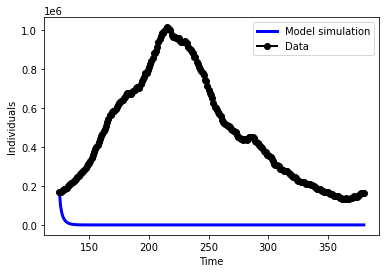

/tmp/ipykernel_7690/4058412055.py:12: RuntimeWarning: invalid value encountered in log
  nll = sum(y) - sum(data*np.log(y))


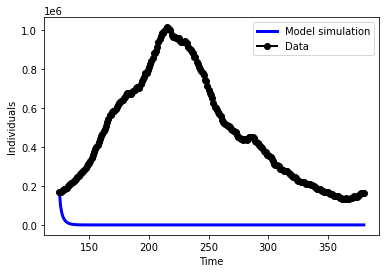

3
[[6.59326397e+09 3.21286258e+10 7.09057261e+03]
 [3.21286258e+10 1.95426409e+11 9.13361630e+04]
 [7.09057261e+03 9.13361630e+04 9.09285631e-02]]
Starting profile...
0 0.4


/tmp/ipykernel_7690/4058412055.py:12: RuntimeWarning: invalid value encountered in log
  nll = sum(y) - sum(data*np.log(y))


0 0.3888888888888889
0 0.3777777777777778
0 0.3666666666666667
0 0.35555555555555557
0 0.3444444444444445
0 0.33333333333333337
0 0.3222222222222223
0 0.31111111111111117
0 0.30000000000000004
1 0.41111111111111115
1 0.4222222222222222
1 0.43333333333333335
1 0.4444444444444445
1 0.45555555555555555
1 0.4666666666666667
1 0.47777777777777775
1 0.4888888888888889
1 0.5
['gamma', 'k']
[0.25, 80000.0]
Starting profile...
0 0.25
0 0.24305555555555555
0 0.2361111111111111
0 0.22916666666666666
0 0.2222222222222222
0 0.2152777777777778
0 0.20833333333333334
0 0.2013888888888889
0 0.19444444444444445
0 0.1875
1 0.2569444444444444
1 0.2638888888888889
1 0.2708333333333333
1 0.2777777777777778
1 0.2847222222222222
1 0.2916666666666667
1 0.2986111111111111
1 0.3055555555555556
1 0.3125
['beta', 'k']
[0.4, 80000.0]
Starting profile...
0 80000.0
0 77777.77777777778
0 75555.55555555556
0 73333.33333333333
0 71111.11111111111
0 68888.88888888889
0 66666.66666666667
0 64444.444444444445
0 62222.22222

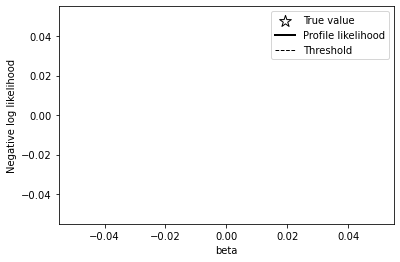

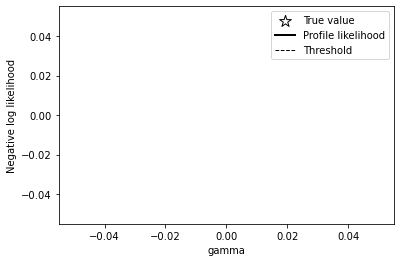

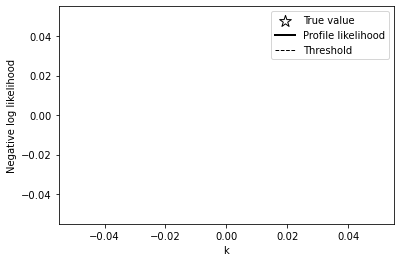

In [40]:
import scipy.optimize as optimize
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


from scipy.integrate import odeint as ode




#### Load Data ####
#times = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98]
#data = [97, 271, 860, 1995, 4419, 6549, 6321, 4763, 2571, 1385, 615, 302, 159, 72, 34]
times=np.linspace(125,380,380-125+1)
data=np.array(Data['active case'][125:381])
#shortened version for seeing how truncated data affects the estimation
#times = times[0:7]
#data = data[0:7]

#### Set initial parameter values and initial states ####
params = [0.4, 0.25, 80000.0]#make sure all the params and inition states are float
paramnames = ['beta', 'gamma', 'k']
ini = x0fcn(params,data)
print(ini)

#### Simulate and plot the model ####
res = ode(model, ini, times, args=(params,))
print(res)
sim_measure = yfcn(res, params)
print(sim_measure)
plt.plot(times, sim_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()


#### Parameter estimation ####
optimizer = optimize.minimize(NLL, params, args=(data, times), method='Nelder-Mead')
paramests = np.abs(optimizer.x)
iniests = x0fcn(paramests, data)

#### Re-simulate and plot the model with the final parameter estimates ####
xest = ode(model, iniests, times, args=(paramests,))
est_measure = yfcn(xest, paramests)
plt.plot(times, est_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()

#### Calculate the simplified Fisher Information Matrix (FIM) ####
FIM = minifisher(times, params, data, delta = 0.001)
print(np.linalg.matrix_rank(FIM)) #calculate rank of FIM
print(FIM)

#### Generate profile likelihoods and confidence bounds ####
threshold = stats.chi2.ppf(0.95,len(paramests))/2.0 + optimizer.fun
perrange = 0.25 #percent range for profile to run across

profiles={}
for i in range(len(paramests)):
	profiles[paramnames[i]] = proflike(paramests, i, NLL, times, data, perrange=perrange)
	plt.figure()
	plt.scatter(paramests[i], optimizer.fun, marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
	plt.plot(profiles[paramnames[i]]['profparam'], profiles[paramnames[i]]['fcnvals'], 'k-', linewidth=2, label='Profile likelihood')
	plt.axhline(y=threshold, ls='--',linewidth=1.0, label='Threshold', color='k')
	plt.xlabel(paramnames[i])
	plt.ylabel('Negative log likelihood')
	plt.legend(scatterpoints = 1)
	paramnames_fit = [ n for n in paramnames if n not in [paramnames[i]]]
	paramests_fit = [v for v in paramests if v not in [paramests[i]]]
	print(paramnames_fit)
	print(paramests_fit)

	#plot parameter relationships
	#for j in range(profiles[paramnames[i]]['fitparam'].shape[1]):
	#	plt.figure()
	#	plt.plot(profiles[paramnames[i]]['profparam'],profiles[paramnames[i]]['fitparam'][:,j],'k-', linewidth=2, label=paramnames_fit[j])
	#	plt.scatter(paramests[i], paramests_fit[j], marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
	#	plt.xlabel(paramnames[i])
	#	plt.ylabel(paramnames_fit[j])
	#	plt.legend(scatterpoints = 1)
print(profiles)
plt.show()